In [5]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [6]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [14]:
import os
files = os.listdir("dataset")

import csv

class Route:
    def __init__(self, phi, v, M, IMU_v, IMU_alpha):
        self.phi = phi
        self.v = v
        self.M = M
        self.IMU_v = IMU_v
        self.IMU_alpha = IMU_alpha
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

maxVDot = [0]*3
maxAlphaDot = [0]*3
allV = []
for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        IMU_v = []
        IMU_alpha = []
        
        maxAngle2 = 0
        maxSpeed2 = 0
        maxTorque2 = 0

        maxVDot2 = [0]*3
        maxAlphaDot2 = [0]*3
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            allV.append(float(row[2]))
            M.append(float(row[3]))
            
            vPacket = [float(row[i]) for i in range(4, 7)]
            alphaPacket = [float(row[i]) for i in range(7, 10)]
            IMU_v.append(vPacket)
            IMU_alpha.append(alphaPacket)
            
            maxAngle2 = max(abs(float(row[1])), maxAngle2)
            maxSpeed2 = max(abs(float(row[2])), maxSpeed2)
            maxTorque2 = max(abs(float(row[3])), maxTorque2)
            
            for i in range(3):
                maxVDot2[i] = max(abs(float(row[4+i])), maxVDot2[i])
                maxAlphaDot2[i] = max(abs(float(row[7+i])), maxAlphaDot2[i])
        if min(v) > 20:
            routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M), torch.tensor(IMU_v).permute(1,0), torch.tensor(IMU_alpha).permute(1,0)))
            allRows += len(phi)
            maxAngle = max(maxAngle, maxAngle2)
            maxSpeed = max(maxSpeed, maxSpeed2)
            maxTorque = max(maxTorque, maxTorque2)
            for i in range(3):
                maxVDot[i] = max(maxVDot[i], maxVDot2[i])
                maxAlphaDot[i] = max(maxAlphaDot[i], maxAlphaDot2[i])


print(allRows)
print(maxAngle, maxSpeed, maxTorque, maxVDot, maxAlphaDot)

444077
21.299999237060547 38.301265716552734 1.0 [17.774017333984375, 9.707061767578125, 11.07452392578125] [0.10943603515625, 0.3661956787109375, 0.1673583984375]


(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         1206.,  3260.,  2569.,  2926.,  2964.,  3752.,  4676.,  6838.,
         6908.,  3883.,  5451.,  5740.,  4689.,  5507.,  6379.,  9385.,
         8874., 10130., 11378., 10522., 13011., 12044., 11327.,  7823.,
         8157.,  8398.,  8268.,  6957., 10207.,  9435.,  5805.,  6824.,
         6365.,  9860., 10005., 12062., 13745., 14584., 20473., 18103.,
        14331., 12565., 13553., 16417.,  7433.,  5954.,  4611.,  4077.,
         3965.,  2434.,  2542.,  3051.,  1047.,  2074.,  4431.,  4518.,
         4368.,  2461.,  1823.,  1345.,   587.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.]),
 array([15.        , 15.3030303 , 15.60606061, 15.90909091, 16.21212121,
        16.51515152, 16.81818

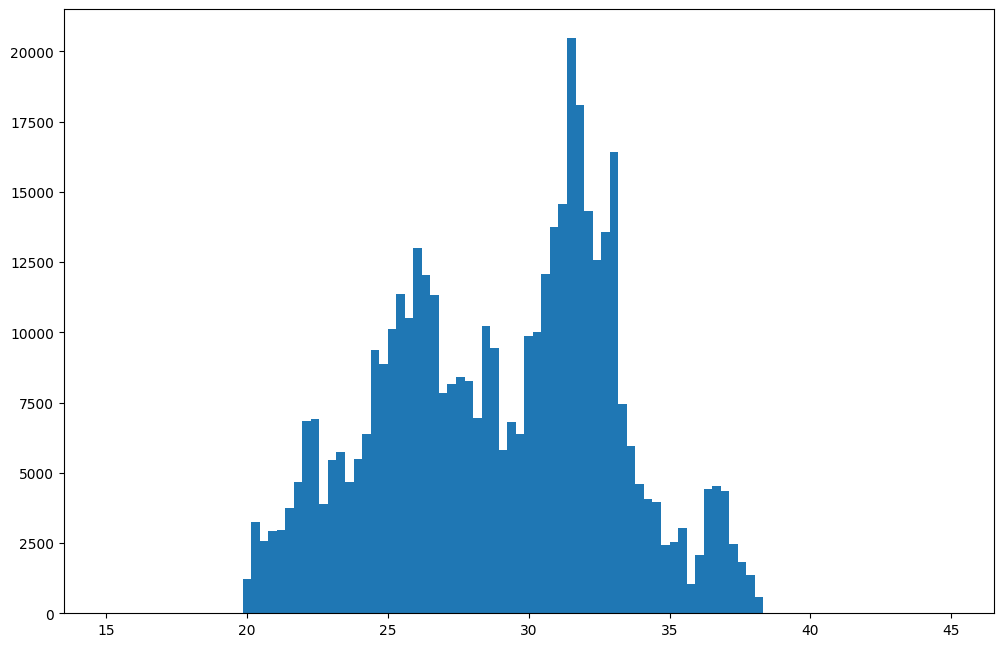

In [15]:
plt.hist(allV, bins=np.linspace(15, 45, 100))

In [93]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

prev_data = 100
fwd_data = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


all_routes = len(routes)
print(f"{all_routes} routes")
test_count = int(all_routes*0.35)
test_routes_id = [randrange(all_routes) for _ in range(test_count)]
test_routes_id = [23, 14, 25, 20, 77, 6, 40, 4, 31, 60, 73, 72, 64, 36, 12, 35, 4, 6, 8, 41, 33, 35, 51, 0, 24, 71, 23]

train_routes = [routes[i] for i in range(all_routes) if i not in test_routes_id]
test_routes = [routes[i] for i in range(all_routes) if i in test_routes_id]
#Phi, v, M_prev, M_fut, IMU_v, IMU_alpha
groups = [4, 20, 50, 10, 10, 10]

input_length = prev_data//groups[0] + prev_data//groups[1] + prev_data//groups[2] + fwd_data[-1]//groups[3] + 3*prev_data//groups[4] + 3*prev_data//groups[5]
output_length = len(fwd_data)

def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data[-1], 5):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            v = route.v[idx-prev_data : idx]/maxSpeed
            M_prev = route.M[idx-prev_data : idx]/maxTorque
            M_fut = route.M[idx : idx+fwd_data[-1]]/maxTorque
            
            phi = phi.reshape(-1, groups[0]).mean(axis=1)
            v = v.reshape(-1, groups[1]).mean(axis=1)
            M_prev = M_prev.reshape(-1, groups[2]).mean(axis=1)
            M_fut = M_fut.reshape(-1, groups[3]).mean(axis=1)
            
            IMU_v = [(route.IMU_v[i][idx-prev_data:idx]/maxVDot[i]).reshape(-1, groups[4]).mean(axis=1) for i in range(3)]
            IMU_alpha = [(route.IMU_alpha[i][idx-prev_data:idx]/maxAlphaDot[i]).reshape(-1, groups[5]).mean(axis=1) for i in range(3)]
            
            o = torch.zeros((output_length,))
            for i in range(output_length):
                o[i] = route.phi[idx+fwd_data[i]]/maxAngle
            
            data = (phi, v, M_prev, M_fut, IMU_v[0], IMU_v[1], IMU_v[2], IMU_alpha[0], IMU_alpha[1], IMU_alpha[2])
            data_input = np.concatenate(data)
            i_data.append(data_input)
            o_data.append(o)
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set), test_routes_id)

  0%|          | 0/55 [00:00<?, ?it/s]

78 routes


100%|██████████| 23/23 [00:09<00:00,  2.39it/s]

59985 25768 [23, 14, 25, 20, 77, 6, 40, 4, 31, 60, 73, 72, 64, 36, 12, 35, 4, 6, 8, 41, 33, 35, 51, 0, 24, 71, 23]


In [94]:
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

1874
806


In [95]:
# base_size = prev_data//group_base
# IMU_size = prev_data//group_IMU
# torque_size = (prev_data + fwd_data)//group_base
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_length),
            nn.Tanh()
        )

        
    def forward(self, x):
        return self.linear_relu_stack(x)
print(input_length)

102


In [96]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = loss.item()*maxAngle*maxAngle
    if debug:
        print(f"Train loss: {loss}")
    return loss

def test_loop(dataloader, model, loss_fn, debug):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*maxAngle*maxAngle

    test_loss /= num_batches
    if debug:
        print(f"Test  loss: {test_loss} \n")
    return test_loss

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

torch.Size([64, 102])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
19722


Epoch 0
Train loss: 2.6623215921350867
Test  loss: 2.074593738846109 

Epoch 1
Train loss: 1.301498119426905
Test  loss: 1.3515903111324958 

Epoch 2
Train loss: 1.6989109517558882
Test  loss: 1.148015777279552 

Epoch 3
Train loss: 1.3448871611533886
Test  loss: 0.9959655530034945 

Epoch 4
Train loss: 1.9328250338060105
Test  loss: 0.9045920609492106 

Epoch 5
Train loss: 1.0460433708719379
Test  loss: 0.8525892329672695 

Epoch 6
Train loss: 1.3749367712061848
Test  loss: 0.8184626740773174 

Epoch 7
Train loss: 0.7577528381776123
Test  loss: 0.7918983265663344 

Epoch 8
Train loss: 1.2595844527939541
Test  loss: 0.7837247250623682 

Epoch 9
Train loss: 0.8511765003435688
Test  loss: 0.7610877191377085 

Epoch 10
Train loss: 1.4857590215375003
Test  loss: 0.7452501816128163 

Epoch 11
Train loss: 1.0130923412090564
Test  loss: 0.7387936457519948 

Epoch 12
Train loss: 1.4405650299847699
Test  loss: 0.7206366113287279 

Epoch 13
Train loss: 1.0118026688014572
Test  loss: 0.7180171026

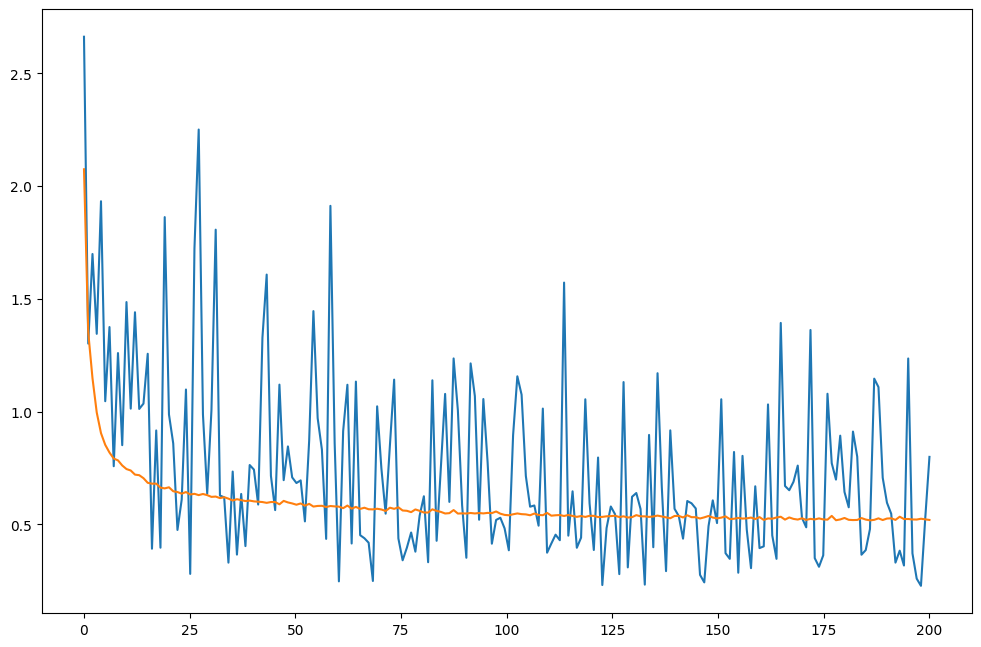

In [97]:
epochs = 200
skip = 1
loss_t = []
loss_e = []
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    loss_t.append(train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0))
    loss_e.append(test_loop(test_dataloader, model, loss_fn, t%skip==0))

plt.plot(np.linspace(0, epochs, epochs), loss_t)
plt.plot(np.linspace(0, epochs, epochs), loss_e)

-4.57499988977338 initial angle
tensor([-4.2000, -4.2000, -4.0500, -3.4500, -2.5500, -2.5500, -2.5500, -2.4000,
        -2.4000, -2.4000])
tensor([-4.4696, -4.1518, -3.7201, -3.3592, -3.1219, -3.0816, -3.0445, -2.9045,
        -2.7256, -2.6176], grad_fn=<MulBackward0>)


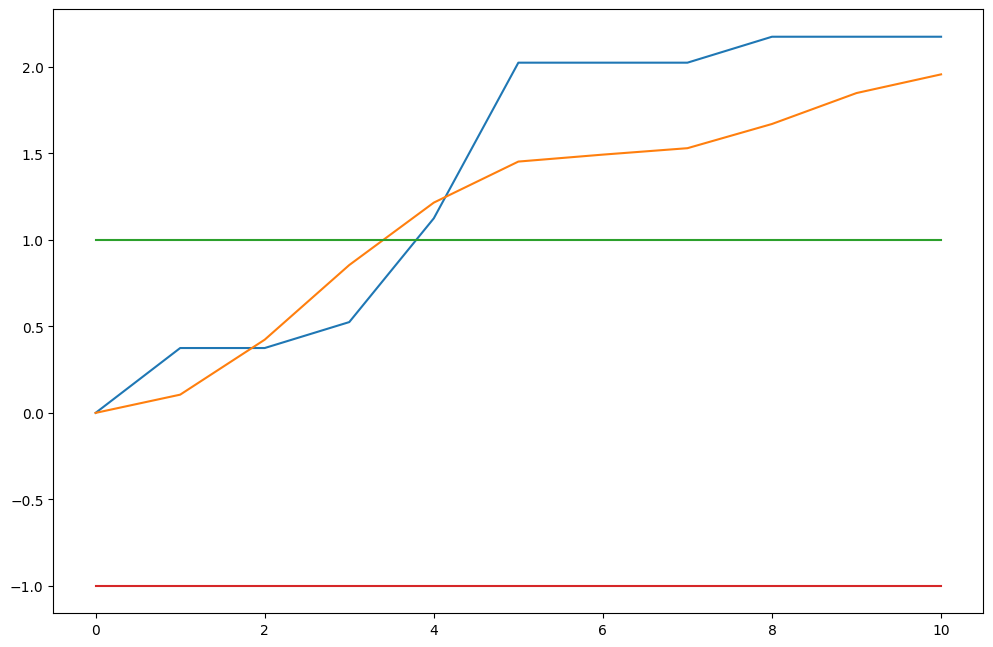

In [105]:
random_sample = test_set[randrange(len(test_set))]
initial_angle = random_sample[0][prev_data//groups[0]-1]*maxAngle
print(initial_angle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
torch_data_output = model(torch_data_input)
print(torch_data_output*maxAngle)

ls_good = [0] +[random_sample[1][i]*maxAngle - initial_angle for i in range(output_length)]
ls_pred = [0] +[torch_data_output[i]*maxAngle - initial_angle for i in range(output_length)]

plt.plot(np.linspace(0, output_length, output_length+1), ls_good)
plt.plot(np.linspace(0, output_length, output_length+1), ls_pred)
plt.plot(np.linspace(0, output_length, output_length+1), np.ones((output_length+1,))*1)
plt.plot(np.linspace(0, output_length, output_length+1), np.ones((output_length+1,))*-1)

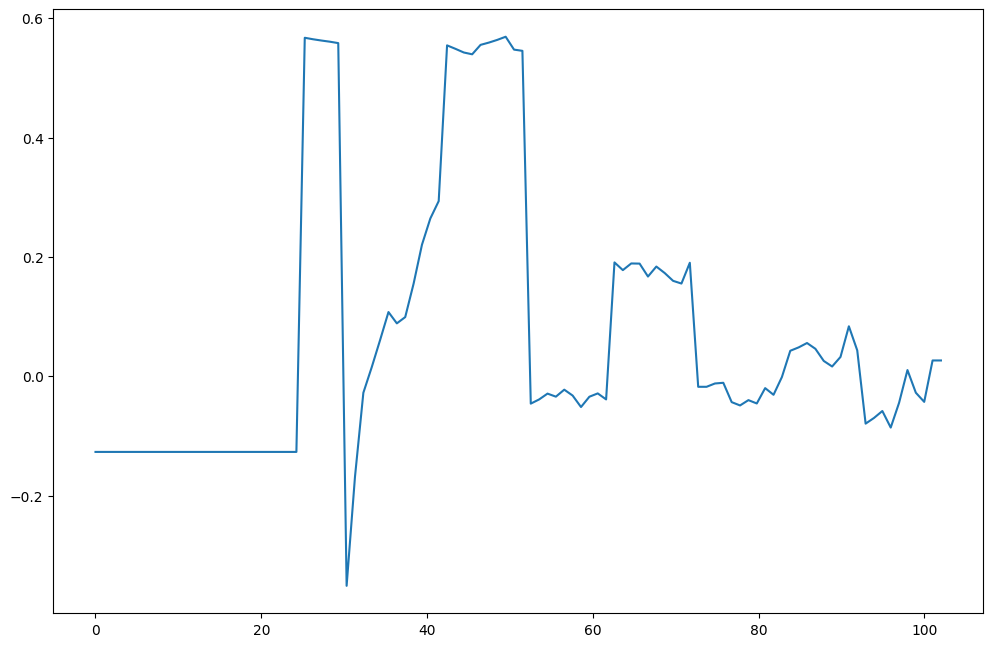

In [106]:
random_sample = test_set[randrange(len(test_set))]
data_input = random_sample[0]
ln = len(data_input)
plt.plot(np.linspace(0, ln, ln), data_input)

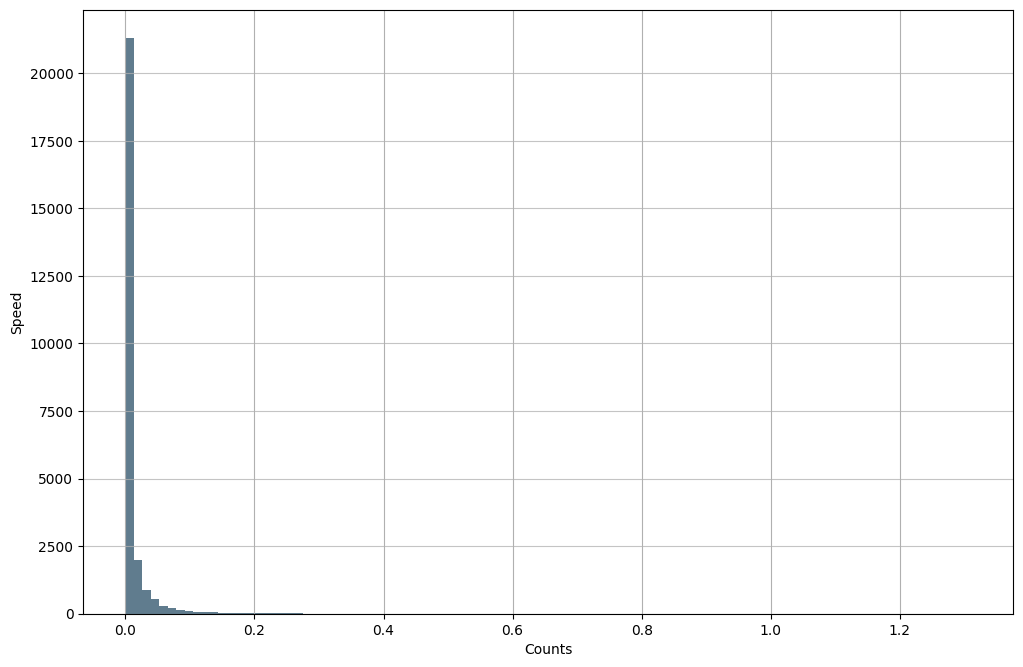

In [107]:
import pandas as pd
lshape = []
for random_sample in test_set:

    data_input = random_sample[0]
    torch_data_input = torch.from_numpy(data_input)
    torch_data_output = model(torch_data_input)

    ls_good = [random_sample[1][i]*maxTorque for i in range(output_length)]
    ls_pred = [torch_data_output[i]*maxTorque for i in range(output_length)]
    mse = sum([(ls_good[i].item()-ls_pred[i].item())**2 for i in range(output_length)])
    lshape.append(mse)
size, scale = 1000, 20
commutes = pd.Series(np.array(lshape))

commutes.plot.hist(grid=True, bins=100, color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [329]:
torch.save(model, 'model_s2.pth')